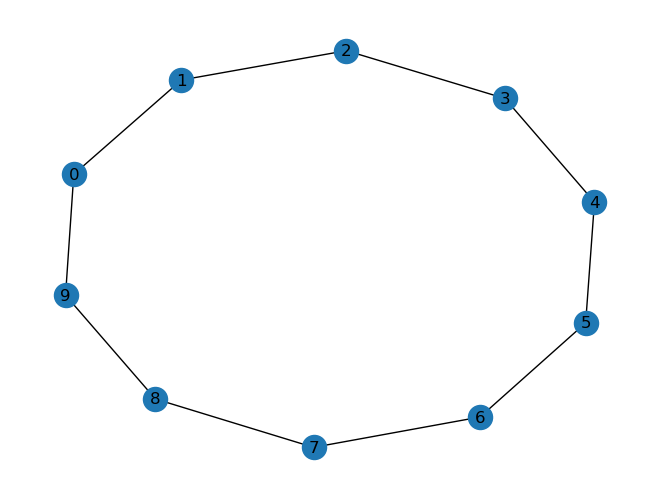

In [68]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

graph_state = nx.Graph()
graph_state.add_nodes_from(list(range(10)))
#graph_state.add_edges_from([(0, 2), (0, 3), (1, 2), (1, 3)])
#graph_state.add_edges_from([(0, 1), (0, 3), (2, 1), (2, 3)])
#graph_state.add_edges_from([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]])
#graph_state.add_edges_from([[0, 1], [1, 5], [5, 3], [3, 4], [4, 2], [2, 0]])
graph_state.add_edges_from([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0]])

nx.draw(graph_state, with_labels=True)

In [69]:
class Algorithm:
    def __init__(self, state: nx.Graph) -> None:
        """
        Initializes X/Z tableus as an NxN where N is the number of photons. Automatically runs the height function 
        and adds emitters to make X/Z an MxM where M is the number of photons + number of emitters.

        Parameters
        ----------
        state : nx.Graph
            Networkx graph containing node and edge information
        """

        self.operations = list()

        #Initializes the state
        self.num_photons = state.number_of_nodes()
        self.num_emitters = 0
        self.dim = self.num_photons
        self.X = np.identity(self.num_photons, int)
        self.Z = nx.adjacency_matrix(state).todense()
        self.S = np.ones(self.num_photons, int)
        self.rref()

        #State with emitters
        self.num_photons = self.num_photons
        self.num_emitters = max(self.height())
        self.dim = self.num_photons + self.num_emitters
        self.X = np.pad(self.X, (0, self.num_emitters), mode='constant')
        self.Z = np.pad(self.Z, (0, self.num_emitters), mode='constant')
        self.S = np.pad(self.S, (0, self.num_emitters), mode='constant')

        #Updates stabilizers w/emitters
        for i in range(self.num_photons, self.dim):
            self.Z[i][i] = 1
            self.S[i] = 1
    

    def __str__(self) -> str:
        """
        Prints out the individual tableus.

        Returns
        -------
        tab_str : str
            String containing information about each tableu
        """

        tab_str = "X tableu\n" + str(self.X) + "\n\nZ tableu\n" + str(self.Z) + "\n\nS tableu\n" + str(self.S)
        return tab_str


    def stabilizers(self, formatted: bool = True):
        """
        Determines what the stabilizers look like as Pauli strings and prints them.
        'Formatted' determines if the stabilizers are printed as a matrix like object.

        Parameters
        ----------
        formatted : bool
            Determines if the stabilizers are printed as a matrix like object, defaults to True.
        
        Returns
        -------
        string / stabilizers 
            stabilizers
        """

        stabilizers = list()
        for i in range(self.dim):
            i_stabilizer = ""
            for j in range(self.dim):
                if self.X[i][j] + self.Z[i][j] == 2:
                    i_stabilizer += "Y"
                elif self.X[i][j] == 1:
                    i_stabilizer += "X"
                elif self.Z[i][j] == 1:
                    i_stabilizer += "Z"
                else:
                    i_stabilizer += "I"
            stabilizers.append(i_stabilizer)
        
        if formatted:
            string = ''
            for i in range(self.dim):
                string += ('+ ' if self.S[i] == 1 else '- ')
                string += stabilizers[i] + '\n'
            print(string)
        else:
            print(stabilizers)


    def add_rows(self, i_add: int, i_base: int) -> None:
        """
        Combines two stabilizers

        Parameters
        ----------
        i_add : int
            index of row to add
        i_base : int
            index of row being added to
        """

        self.X[i_base] = np.mod(np.add(self.X[i_add], self.X[i_base]), 2)
        self.Z[i_base] = np.mod(np.add(self.Z[i_add], self.Z[i_base]), 2)


    def swap_rows(self, row_a: int, row_b: int) -> None:
        """
        Swaps two stabilizers

        Parameters
        ----------
        row_a : int
            index of first stabilizer to swap
        row_b : int
            index of second stabilizer to swap
        """

        self.X[[row_a, row_b]] = self.X[[row_b, row_a]]
        self.Z[[row_a, row_b]] = self.Z[[row_b, row_a]]


    def hadamard(self, qubit: int, write: bool = True) -> None:
        """
        Performs a hadamard gate on a specified qubit by performing a bit flip on X/Z Paulis and 
        a phase change on Y Paulis
        
        Parameters
        ----------
        qubit : int
            qubit to apply hadamard to
        write : bool
            writes to operation list if true (default)
        """
        for i in range(self.dim): 
            if self.X[i][qubit] + self.Z[i][qubit] == 1:
                self.X[i][qubit] = (self.X[i][qubit] + 1) % 2 
                self.Z[i][qubit] = (self.Z[i][qubit] + 1) % 2
            elif self.X[i][qubit] + self.Z[i][qubit] == 2:
                self.S[i] *= -1
        if write:
            self.operations.append(["H", int(qubit)])
    

    def phase(self, qubit: int, write: bool = True) -> None:
        """
        Performs a phase gate on a specified qubit by performing a bitwise addition
        of the X column to the Z column and a phase change on Y Paulis
        
        Parameters
        ----------
        qubit : int
            qubit to apply phase to
        write : bool
            writes to operation list if true (default)
        """

        for i in range(self.dim):
            self.Z[i][qubit] = (self.Z[i][qubit] + self.X[i][qubit]) % 2
            if self.Z[i][qubit] + self.X[i][qubit] == 2:
                self.S[i] *= -1
        if write:
            self.operations.append(["P", int(qubit)])


    def cnot(self, control: int, target: int, write: bool = True) -> None:
        """
        Performs a CNOT gate between a control and target qubit by adding the X control to the X target
        and adding the Z target to the Z control, also checks for phase change case.
        
        Parameters
        ----------
        control : int
            qubit to use as control in CNOT
        target : int
            qubit to use as target in CNOT
        write : bool
            writes to operation list if true (default)
        """

        for i in range(self.dim):
            if self.X[i][control] == self.X[i][target] == self.Z[i][control] == self.Z[i][target] == 1:
                self.S[i] *= -1
            self.X[i][target] = (self.X[i][control] + self.X[i][target]) % 2
            self.Z[i][control] = (self.Z[i][control] + self.Z[i][target]) % 2
            if self.X[i][control] == self.X[i][target] == self.Z[i][control] == self.Z[i][target] == 1:
                self.S[i] *= -1
        if write:
            self.operations.append(["CNOT [c/t]", int(control), int(target)])


    def rref(self) -> None:
        """
        Row reduces stabilizers to be in RREF form
        """

        row = 0
        for index in range(self.dim):
            if row > self.dim:
                break

            x_column = self.X[:, index]
            z_column = self.Z[:, index]

            num_x, num_y, num_z = 0, 0, 0

            #Removes additional paulis of the same type
            for i in range(row, self.dim):
                if x_column[i] == 1 and z_column[i] == 0:
                    if num_x == 0:
                        first_x = i
                    num_x += 1
                    if num_x == 2:
                        self.add_rows(first_x, i)
                        num_x -= 1
                if x_column[i] == 1 and z_column[i] == 1:
                    if num_y == 0:
                        first_y = i
                    num_y += 1
                    if num_y == 2:
                        self.add_rows(first_y, i)
                        num_y -= 1
                if x_column[i] == 0 and z_column[i] == 1:
                    if num_z == 0:
                        first_z = i
                    num_z += 1
                    if num_z == 2:
                        self.add_rows(first_z, i)
                        num_z -= 1

            num_pauli = num_x + num_y + num_z
            xz_column = np.add(x_column, z_column)

            if num_pauli == 1:
                first = np.where(xz_column[row:] >= 1)[0][0] + row
                self.swap_rows(first, row)
                
                row += 1

            elif num_pauli == 2:
                x_index = np.where(x_column[row:] == 1)[0]
                z_index = np.where(z_column[row:] == 1)[0]

                if len(x_index) == 2:
                    first_x = x_index[0] + row
                    first_z = x_index[1] + row
                    print('y')
                elif len(z_index) == 2:
                    first_x = z_index[0] + row
                    first_z = z_index[1] + row
                    print('y')
                else:
                    first_x = x_index[0] + row
                    first_z = z_index[0] + row
                
                self.swap_rows(row+1, first_z)
                first_x = np.where(x_column[row:] == 1)[0][0] + row
                self.swap_rows(row, first_x)

                row += 2

            elif num_pauli == 3:
                y_index = np.where(xz_column == 2)[0][0]
                xz_index = np.where(xz_column == 2)[0]
                print('3')
    
    def simplify(self):
        de_stabs = []

        for i in range(self.dim):
            x_indices = np.where(self.X[i] == 1)[0]
            z_indices = np.where(self.Z[i] == 1)[0]
            if len(z_indices) == 1 and len(x_indices) == 0:
                de_stabs.append([i, int(z_indices[0])])
            
        for pair in de_stabs:
            z_column = self.Z[:, pair[1]]
            x_column = self.X[:, pair[1]]
            z_paulis = [int(i) for i in np.where(z_column == 1)[0]]
            x_paulis = [int(i) for i in np.where(x_column == 1)[0]]
            z_paulis.remove(pair[0])
            
            if len(z_paulis) > 0:
                for z_loc in z_paulis:
                    if z_loc not in x_paulis:
                        self.add_rows(pair[0], z_loc)


    def height(self) -> list[int]:
        """
        Calculates the heights of a given set of stabilizers
        
        Returns
        -------
        heights : list[int]
            heights of a given set of stabilizers
        """

        heights = []
        ranks = []
        XZ = np.add(self.X, self.Z)
        for row in XZ:
            ranks.append(np.where(row >= 1)[0][0] + 1)
        for i in range(self.dim):
            height = self.dim - i - sum(j > i for j in ranks)
            heights.append(height)
        return heights


    def reverse_measurement(self, photon: int) -> None:
        """
        Performs a time reversed measurement on a photon
        
        Parameters
        ----------
        photon : int
            photon to apply TRM to
        """

        trm_emitter = 0
        candidate_index = []
        XZ = np.add(self.X, self.Z)
        for i in range(self.dim):
            row = XZ[i][0:self.num_photons]
            if np.sum(row) == 0:
                candidate_index.append(i)

        for j in candidate_index:
            one_z = np.sum(self.Z[j][self.num_photons:self.dim]) == 1 and np.sum(self.X[j]) == 0
            if one_z:
                trm_emitter = np.where(self.Z[j] == 1)[0][0]
                break
        self.hadamard(trm_emitter, False)
        self.cnot(trm_emitter, photon, False)
        print("TRM", trm_emitter, photon)
        self.operations.append(["TRM", int(trm_emitter), int(photon)])


    def emission(self, photon: int) -> None:
        """
        Performs a time reversed emission on a photon
        
        Parameters
        ----------
        photon : int
            photon to apply TRE to
        """

        print(photon)
        XZ = np.add(self.X, self.Z)
        self.stabilizers()
        self.simplify()
        for i in range(self.dim):
            pauli_index = list(np.where(XZ[i] >= 1)[0])
            if len(pauli_index) < 2 or photon not in pauli_index or pauli_index[1] < self.num_photons:
                pass
            else:
                emitter = pauli_index[1]

                while len(pauli_index) > 2:
                    dud = pauli_index[-1]
                    for qubit in [emitter, dud]:
                        if self.X[i][qubit] == self.Z[i][qubit] == 1:
                            self.phase(qubit)
                        elif self.X[i][qubit] == 1:
                            self.hadamard(qubit)
                    self.cnot(dud, emitter)
                    pauli_index.pop()
                
                for qubit in [photon, emitter]:
                    if self.X[i][qubit] == self.Z[i][qubit] == 1:
                        self.phase(qubit)
                    elif self.X[i][qubit] == 1:
                        self.hadamard(qubit)
                self.cnot(emitter, photon)
                break

        print("Absorption", emitter, photon)
        
        try:
            self.temp_emitter = emitter
        except:
            self.temp_emitter = self.num_photons
        

    def run(self):
        """
        Runs the algorithm to obtain a time reversed circuit
        """

        running = True
        photon = self.num_photons - 1
        self.rref()
        while running:
            print("photon:", photon)
            heights = self.height()
            if heights[photon] > heights[photon + 1]:
                self.reverse_measurement(photon)
            self.emission(photon)

            z_column = self.Z[:, self.temp_emitter]
            for i in range(self.dim):
                if z_column[i] == 1 and i != self.temp_emitter:
                    self.Z[i] = np.mod(np.add(self.Z[i], self.Z[self.temp_emitter]), 2)
                    pass
            self.rref()
            if photon == 0:
                running = False
            photon -= 1
        print(self.operations)
        self.operations.reverse()
        print(self.operations)
        



alg_state = Algorithm(graph_state)
print(alg_state.num_emitters)

if True:
    alg_state.run()
    print('')
    alg_state.stabilizers(True)

2
photon: 9
TRM 10 9
9
+ XZIIIIIIIZZI
+ ZXZIIIIIIIII
+ IXZIIIIIZXII
+ IZXZIIIIIIII
+ IIZXZIIIIIII
+ IIIZXZIIIIII
+ IIIIZXZIIIII
+ IIIIIZXZIIII
+ IIIIIIZXZIII
+ IIIIIIIZXZZI
+ IIIIIIIIIXXI
+ IIIIIIIIIIIZ

Absorption 10 9
photon: 8
TRM 11 8
8
+ XZIIIIIIIIXI
+ ZXZIIIIIIIII
+ IXZIIIIIZIZZ
+ IZXZIIIIIIII
+ IIZXZIIIIIII
+ IIIZXZIIIIII
+ IIIIZXZIIIII
+ IIIIIZXZIIII
+ IIIIIIZXZIIZ
+ IIIIIIIZXIXI
+ IIIIIIIIIZII
+ IIIIIIIIXIIX

Absorption 11 8
photon: 7
7
+ XZIIIIIIIIXI
+ ZXZIIIIIIIII
+ IXZIIIIIIIZX
+ IZXZIIIIIIII
+ IIZXZIIIIIII
+ IIIZXZIIIIII
+ IIIIZXZIIIII
+ IIIIIZXZIIII
+ IIIIIIZXIIIX
+ IIIIIIIZIIXZ
+ IIIIIIIIZIII
+ IIIIIIIIIZII

Absorption 10 7
photon: 6
6
+ XZIIIIIIZIZZ
+ ZXZIIIIIIIII
+ IXZIIIIIIIIX
+ IZXZIIIIIIII
+ IIZXZIIIIIII
+ IIIZXZIIIIII
+ IIIIZXZIIIII
+ IIIIIZXZZIZI
+ IIIIIIZIIIXX
+ IIIIIIIZIIII
+ IIIIIIIIZIII
+ IIIIIIIIIZII

Absorption 10 6
photon: 5
5
+ XZIIIIIIIIIX
+ ZXZIIIIIIIII
+ IXZIIIIIIIIZ
+ IZXZIIIIIIII
+ IIZXZIIIIIII
+ IIIZXZIIIIII
+ IIIIZXZIZIZI
+ IIIIIZIIIIXI
+ IIIIIIZIII